<a href="https://colab.research.google.com/github/Justabhi96/advanced_computer_vision/blob/master/08_Object_Localization_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the pokemon of different sizes also flip the pokemon randomly with arbitrary background

In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [0]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

File ‘charmander-tight.png’ already there; not retrieving.

--2020-02-09 18:49:09--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   931KB/s    in 0.5s    

2020-02-09 18:49:31 (931 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [0]:
!unzip -q backgrounds.zip

In [0]:
import os
os.listdir("backgrounds")

['9.jpg',
 '7.jpg',
 '4.jpg',
 '10.jpg',
 '5.jpg',
 '6.jpg',
 '2.jpg',
 '13.jpg',
 '3.jpg',
 '12.jpg',
 '1.jpg',
 '15.jpg',
 '8.jpg',
 '11.jpg',
 '14.jpg']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image

In [0]:
IMAGE_SIZE = [200, 200, 3]

In [0]:
from glob import glob
backgrounds = []
background_files = glob("backgrounds/*.jpg")
for filename in background_files:
  # they all may not be same size
  bk_img = imageio.imread(filename)
  backgrounds.append(bk_img)

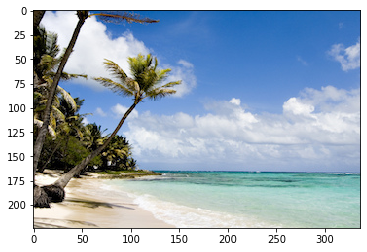

In [0]:
plt.imshow(backgrounds[2])

In [0]:
vgg = VGG16(input_shape = IMAGE_SIZE, weights = "imagenet", include_top = False)

x = Flatten()(vgg.output)
x = Dense(4, activation = "sigmoid")(x)
model = Model(vgg.input, x)

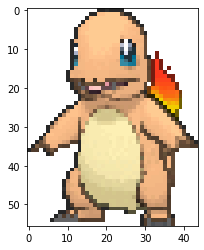

In [0]:
ch_image = imageio.imread("charmander-tight.png")
plt.imshow(ch_image)

In [0]:
ch_image = np.array(ch_image)
ch_h, ch_w, _ = ch_image.shape
ch_h, ch_w

(56, 44)

In [0]:
from skimage.transform import resize
ref_size = IMAGE_SIZE[0]

def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros([batch_size] + IMAGE_SIZE)
      Y = np.zeros([batch_size, 4])

      for i in range(batch_size):
        bg = backgrounds[np.random.choice(len(backgrounds))]
        bg_h, bg_w, _ = bg.shape

        rand_h = np.random.randint(0, bg_h - ref_size)
        rand_w = np.random.randint(0, bg_w - ref_size)

        X[i] = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

        # to make charmander bigger or smaller
        scale = 0.5 + np.random.random() #[0.5, 1.5]
        new_h = int(ch_h * scale)
        new_w = int(ch_w * scale)

        new_ch_img = resize(ch_image, (new_h, new_w), 
                            preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
        if np.random.random() < 0.5:
          new_ch_img = np.fliplr(new_ch_img)

        row0 = np.random.randint(0, ref_size - new_h)
        col0 = np.random.randint(0, ref_size - new_w)
        row1 = row0 + new_h
        col1 = col0 + new_w

        # to paste charmander in background without removing background
        mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
        bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place the pokemon
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
        bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
        X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

        Y[i, 0] = row0/ref_size
        Y[i, 1] = col0/ref_size
        Y[i, 2] = (col1-col0)/ref_size
        Y[i, 3] = (row1-row0)/ref_size

      yield X/255.0, Y

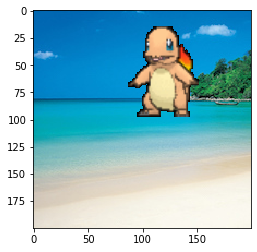

In [0]:
xx = None
yy = None
for x, y in image_generator():
  xx, yy = x, y
  break
plt.imshow(xx[10])

In [0]:
# Notice learning rate is 10th of previous netebook
model.compile(optimizer=Adam(lr = 0.0001), loss = "binary_crossentropy")
model.fit_generator(image_generator(), epochs = 5, steps_per_epoch=50)

  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/5
50/50 [==============================] - 54s 1s/step - loss: 0.5780
Epoch 2/5
50/50 [==============================] - 38s 756ms/step - loss: 0.5494
Epoch 3/5
50/50 [==============================] - 39s 775ms/step - loss: 0.5425
Epoch 4/5
50/50 [==============================] - 39s 773ms/step - loss: 0.5449
Epoch 5/5
50/50 [==============================] - 39s 774ms/step - loss: 0.5445


In [0]:
from matplotlib.patches import Rectangle

def make_prediction():
  bg = backgrounds[np.random.choice(len(backgrounds))]
  bg_h, bg_w, _ = bg.shape

  rand_h = np.random.randint(0, bg_h - ref_size)
  rand_w = np.random.randint(0, bg_w - ref_size)

  x = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

  # to make charmander bigger or smaller
  scale = 0.5 + np.random.random() #[0.5, 1.5]
  new_h = int(ch_h * scale)
  new_w = int(ch_w * scale)

  new_ch_img = resize(ch_image, (new_h, new_w), 
                      preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
  if np.random.random() < 0.5:
    new_ch_img = np.fliplr(new_ch_img)

  row0 = np.random.randint(0, ref_size - new_h)
  col0 = np.random.randint(0, ref_size - new_w)
  row1 = row0 + new_h
  col1 = col0 + new_w

  # to paste charmander in background without removing background
  mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
  bg_slice = x[row0:row1, col0:col1, :] # where we want to place the pokemon
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
  bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
  x[row0:row1, col0:col1, :] = bg_slice # put the slice back
  # x[row0:row1, col0:col1, :] = new_ch_img[:,:,:3]

  X = np.expand_dims(x, 0)
  p = model.predict(X/255.0)[0]
  print((p[0]*ref_size, p[1]*ref_size, p[2]*ref_size, p[3]*ref_size))
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle((p[1]*ref_size, p[0]*ref_size), 
                   p[2]*ref_size, p[3]*ref_size, 
                   linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

(71.68761491775513, 140.18611907958984, 42.57993698120117, 53.10512185096741)


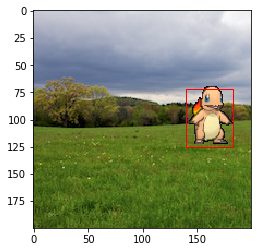

In [0]:
make_prediction()